In [1]:
!pip install tldextract

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 6, Finished, Available)

     |████████████████████████████████| 97 kB 7.2 MB/s eta 0:00:011


In [2]:
import os

# Get the current working directory
cwd = os.getcwd()

# Construct the file path
file_path = os.path.join(cwd, 'Users/Owen.Rotich/')
print(file_path)

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 7, Finished, Available)

/synfs/notebook/11/aml_notebook_mount/Users/Owen.Rotich/


In [3]:
import sys

# Add the directory containing utils.py to the Python path
sys.path.append(os.path.dirname(file_path))

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 8, Finished, Available)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import pickle
from utils import Preprocessor
import numpy as np

/home/owen/miniconda3/envs/surfhound/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [5]:
# Load dataset
df = pd.read_csv('Users/Owen.Rotich/phishing_site_urls.csv')

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 10, Finished, Available)

EXPLORATORY DATASET ANALYSIS

In [6]:
# basic info
df.info()
df.describe()

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 11, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     549346 non-null  object
 1   label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


,url,label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.onion.to/,good
freq,52,392924


In [7]:
# find duplicates
df.duplicated().sum()

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 12, Finished, Available)

42150

In [8]:
# check the data types
df.dtypes

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 13, Finished, Available)

url      object
label    object
dtype: object

In [9]:
# print the number of bad vs good URLs
label_counts = df['label'].value_counts()
print(f'Number of bad URLs: {label_counts["bad"]}')
print(f'Number of good URLs: {label_counts["good"]}')

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 14, Finished, Available)

Number of bad URLs: 156422
Number of good URLs: 392924


StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 15, Finished, Available)

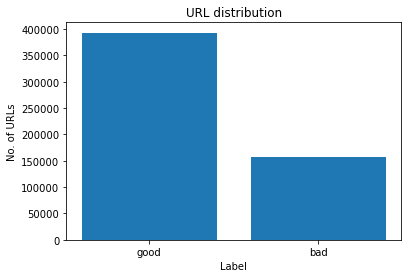

In [10]:
# plot number of URLs in each label
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('No. of URLs')
plt.title('URL distribution')
plt.show()

In [11]:
# Data Cleaning
df = df.dropna()  # remove missing values
df = df.drop_duplicates()  # remove duplicates
df['url'] = df['url'].str.lower()  # convert to lowercase

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 16, Finished, Available)

In [12]:
# Convert labels to binary format ('good' -> 1, 'bad' -> 0)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 17, Finished, Available)

In [13]:
# Initialize the preprocessor and transform the data
preprocessor = Preprocessor()
X = preprocessor.fit_transform(df)
y = df['label']

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 18, Finished, Available)

length of sequences: 177


In [14]:
# Split the data into training and test sets
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 19, Finished, Available)

In [15]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_tr.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 20, Finished, Available)

2023-11-13 20:14:50.739465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 21, Finished, Available)

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_tr, y_tr, epochs=50, batch_size=32, validation_data=(X_ts, y_ts), class_weight=dict(enumerate(class_weights)), callbacks=[early_stopping])

# callbacks=[early_stopping]

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 22, Finished, Available)

2023-11-13 20:14:53.768246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-13 20:14:53.811692: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


Epoch 1/50
12680/12680 [==============================] - 25s 2ms/step - loss: 0.4651 - accuracy: 0.8178 - val_loss: 0.3095 - val_accuracy: 0.8643
Epoch 2/50
12680/12680 [==============================] - 23s 2ms/step - loss: 0.3459 - accuracy: 0.8503 - val_loss: 0.2751 - val_accuracy: 0.8702
Epoch 3/50
12680/12680 [==============================] - 24s 2ms/step - loss: 0.3257 - accuracy: 0.8567 - val_loss: 0.2632 - val_accuracy: 0.8862
Epoch 4/50
12680/12680 [==============================] - 23s 2ms/step - loss: 0.3173 - accuracy: 0.8641 - val_loss: 0.2661 - val_accuracy: 0.8877
Epoch 5/50
12680/12680 [==============================] - 23s 2ms/step - loss: 0.3101 - accuracy: 0.8662 - val_loss: 0.2760 - val_accuracy: 0.8933
Epoch 6/50
12680/12680 [==================

In [18]:
# Evaluate the model
y_pred = model.predict(X_ts)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_ts, y_pred))
print(confusion_matrix(y_ts, y_pred))

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 23, Finished, Available)

              precision    recall  f1-score   support

           0       0.72      0.91      0.80     22704
           1       0.97      0.90      0.93     78736

    accuracy                           0.90    101440
   macro avg       0.85      0.90      0.87    101440
weighted avg       0.92      0.90      0.90    101440

[[20733  1971]
 [ 8134 70602]]


In [19]:
# Save the model and preprocessor
model.save(f'{file_path}surfhound.h5')
with open(f'{file_path}preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

StatementMeta(d5d52fdd-a565-4043-bb61-4b7680650277, 11, 24, Finished, Available)

In [4]:
def is_phishing_url(url):
    # Load the preprocessor and the model
    with open('../server_side_api/preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    model = load_model('../server_side_api/surfhound.h5')

    # Preprocess the URL
    df = pd.DataFrame([[url, None ]], columns=['url','label'])
    X = preprocessor.transform(df)
    print(df)

    # Make a prediction
    prediction = model.predict(X)

    # Return True if the URL is predicted to be phishing, False otherwise
    if prediction[0][0] < 0.5:
      return True
    else:
      return False

In [8]:
while(True):
    bad_url = input("Enter a url: ")
    print(is_phishing_url(bad_url))

NameError: name 'pickle' is not defined